In [ ]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [62]:
DIR = '../data'

In [63]:
def load_data(file_name, sample_rate=0.1, random_seed=42):
    """
    Load data from gzipped JSON file with random sampling.
    
    Parameters:
    - file_name: path to the file
    - sample_rate: proportion of data to sample (default 0.1 for 10%)
    - random_seed: seed for reproducibility
    """
    np.random.seed(random_seed)
    data = []
    
    with gzip.open(file_name) as fin:
        for l in fin:
            # Randomly decide whether to include this record
            if np.random.random() < sample_rate:
                d = json.loads(l)
                data.append(d)
    
    return data

In [64]:
books = load_data(os.path.join(DIR, 'goodreads_books.json.gz'), sample_rate=0.1, random_seed=42)
books_df = pd.DataFrame(books)

print(f"Loaded {len(books_df)} books (10% random sample)")

# Convert numeric columns to appropriate types
numeric_columns = ['average_rating', 'ratings_count', 'text_reviews_count', 'num_pages', 'publication_year']
for col in numeric_columns:
    if col in books_df.columns:
        books_df[col] = pd.to_numeric(books_df[col], errors='coerce')

Loaded 235986 books (10% random sample)


# Exploratory Data Analysis - Goodreads Books Dataset

**Note:** This analysis is performed on a random 10% sample of the complete dataset to ensure computational efficiency while maintaining statistical representativeness.

## 1. Dataset Overview

In [65]:
print(f"Dataset shape: {books_df.shape}")
print(f"Number of books: {len(books_df)}")
print(f"\nColumn names and types:")
print(books_df.dtypes)

Dataset shape: (235986, 29)
Number of books: 235986

Column names and types:
isbn                     object
text_reviews_count      float64
series                   object
country_code             object
language_code            object
popular_shelves          object
asin                     object
is_ebook                 object
average_rating          float64
kindle_asin              object
similar_books            object
description              object
format                   object
link                     object
authors                  object
publisher                object
num_pages               float64
publication_day          object
isbn13                   object
publication_month        object
edition_information      object
publication_year        float64
url                      object
image_url                object
book_id                  object
ratings_count           float64
work_id                  object
title                    object
title_without_series     ob

In [66]:
# Display first few rows
books_df.head()

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,0425040887,4.0,[],US,,"[{'count': '14', 'name': 'to-read'}, {'count':...",,false,4.38,,...,3,,1979.0,https://www.goodreads.com/book/show/378460.The...,https://s.gr-assets.com/assets/nophoto/book/11...,378460,12.0,368291,The Wanting of Levine,The Wanting of Levine
1,184737297X,15.0,[169353],US,,"[{'count': '159', 'name': 'to-read'}, {'count'...",,false,3.93,B007YLTG5I,...,4,,2009.0,https://www.goodreads.com/book/show/6066814-cr...,https://images.gr-assets.com/books/1328724803m...,6066814,186.0,6243149,"Crowner Royal (Crowner John Mystery, #13)","Crowner Royal (Crowner John Mystery, #13)"
2,1463650132,10.0,[],US,,"[{'count': '13', 'name': 'to-read'}, {'count':...",,false,3.98,B005IDOX8E,...,7,,2011.0,https://www.goodreads.com/book/show/12135833-h...,https://s.gr-assets.com/assets/nophoto/book/11...,12135833,71.0,17054142,Holding On,Holding On
3,8864116435,19.0,[],US,ita,"[{'count': '6463', 'name': 'to-read'}, {'count...",,true,4.28,,...,5,Le Strade #202,2012.0,https://www.goodreads.com/book/show/18628480-s...,https://images.gr-assets.com/books/1380976410m...,18628480,116.0,1559207,Stoner,Stoner
4,1597371289,8.0,[],US,eng,"[{'count': '16215', 'name': 'classics'}, {'cou...",,false,3.99,B0083Z3O8Y,...,9,,2005.0,https://www.goodreads.com/book/show/3209316-emma,https://s.gr-assets.com/assets/nophoto/book/11...,3209316,42.0,3360164,Emma,Emma


## 2. Missing Values Analysis

Missing Values Summary:
                                Column  Missing_Count  Missing_Percentage
num_pages                    num_pages          76774               32.53
publication_year      publication_year          60194               25.51
text_reviews_count  text_reviews_count             44                0.02
average_rating          average_rating             44                0.02
ratings_count            ratings_count             44                0.02


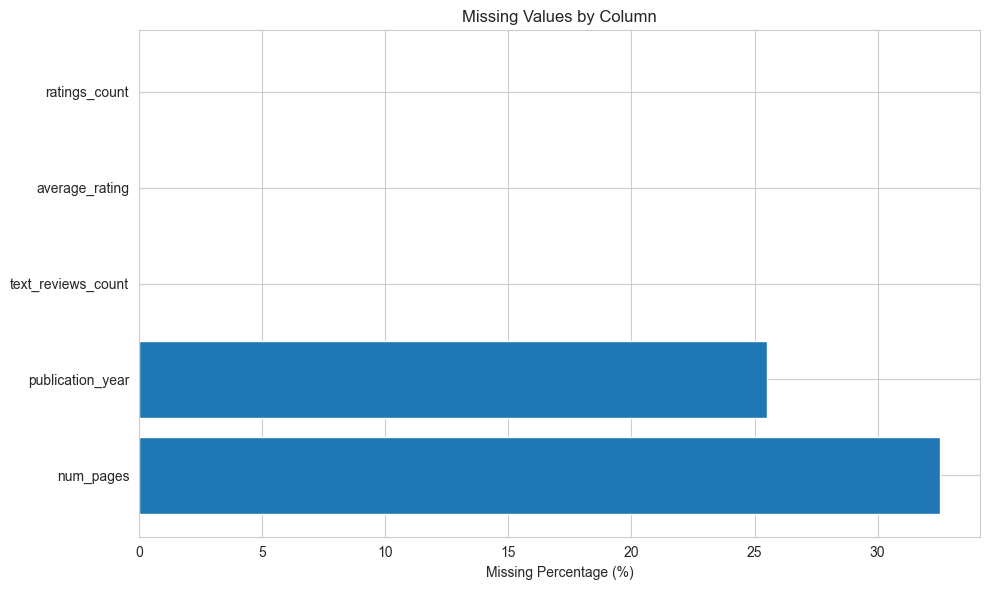

In [67]:
# Calculate missing values
missing_values = pd.DataFrame({
    'Column': books_df.columns,
    'Missing_Count': books_df.isnull().sum(),
    'Missing_Percentage': (books_df.isnull().sum() / len(books_df) * 100).round(2)
})
missing_values = missing_values[missing_values['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("Missing Values Summary:")
print(missing_values)

# Visualize missing values if any exist
if len(missing_values) > 0:
    plt.figure(figsize=(10, 6))
    plt.barh(missing_values['Column'], missing_values['Missing_Percentage'])
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Values by Column')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo missing values found in the dataset!")

## 3. Rating Analysis

Rating Statistics:
count    235942.000000
mean          3.865290
std           0.542425
min           0.000000
25%           3.630000
50%           3.910000
75%           4.160000
max           5.000000
Name: average_rating, dtype: float64


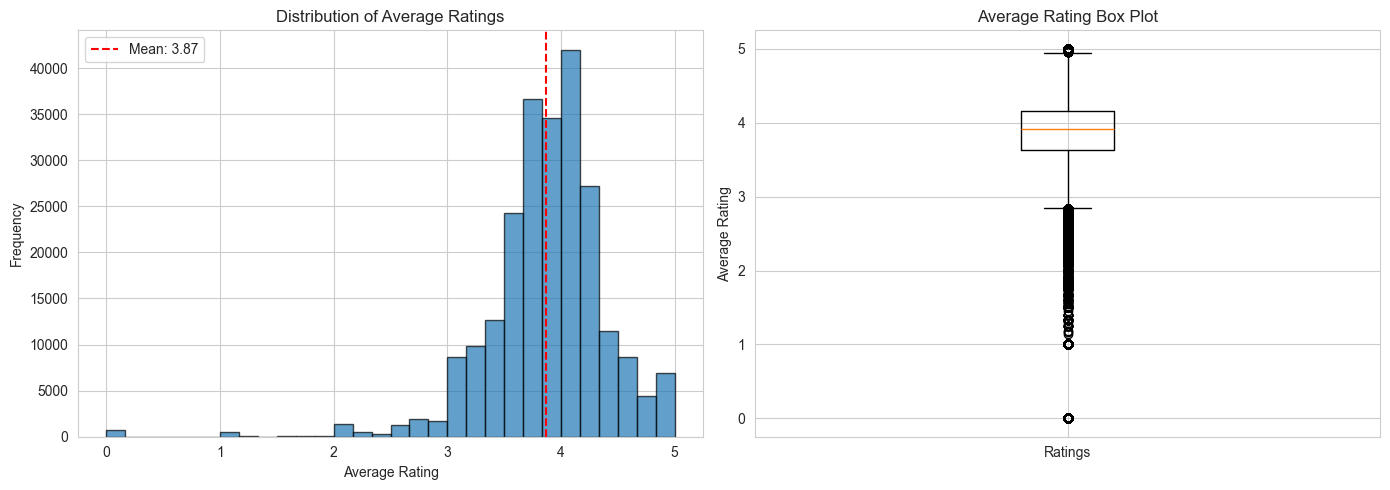

In [68]:
# Extract rating statistics
print("Rating Statistics:")
print(books_df['average_rating'].describe())

# Create rating distribution plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of average ratings
rating_data = books_df['average_rating'].dropna()
axes[0].hist(rating_data, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Average Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Average Ratings')
axes[0].axvline(rating_data.mean(), color='red', linestyle='--', label=f"Mean: {rating_data.mean():.2f}")
axes[0].legend()

# Box plot
axes[1].boxplot(rating_data.tolist())
axes[1].set_ylabel('Average Rating')
axes[1].set_title('Average Rating Box Plot')
axes[1].set_xticklabels(['Ratings'])

plt.tight_layout()
plt.show()


Ratings Count Statistics:
count    2.359420e+05
mean     3.834491e+02
std      9.092177e+03
min      0.000000e+00
25%      6.000000e+00
50%      2.000000e+01
75%      7.700000e+01
max      1.854746e+06
Name: ratings_count, dtype: float64


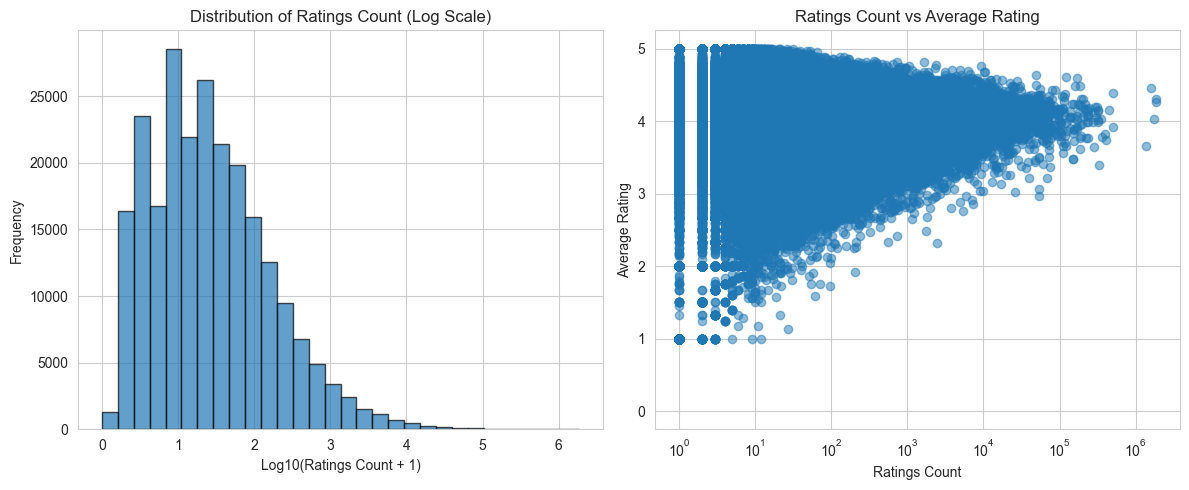

In [69]:
# Ratings count analysis
print("\nRatings Count Statistics:")
print(books_df['ratings_count'].describe())

ratings_count_data = books_df['ratings_count'].dropna()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(np.log10(ratings_count_data + 1), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Log10(Ratings Count + 1)')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings Count (Log Scale)')

plt.subplot(1, 2, 2)
# Filter valid data for scatter plot
valid_data = books_df[['ratings_count', 'average_rating']].dropna()
plt.scatter(valid_data['ratings_count'], valid_data['average_rating'], alpha=0.5)
plt.xlabel('Ratings Count')
plt.ylabel('Average Rating')
plt.title('Ratings Count vs Average Rating')
plt.xscale('log')
plt.tight_layout()
plt.show()

## 4. Popular Shelves/Genres Analysis

Top 20 Most Popular Shelves:
                  shelf  total_count
0               to-read    812397999
47    currently-reading     53309975
148           favorites     31152241
13              fiction     24280914
142            classics     22741900
315             fantasy     18807717
489         young-adult      9570414
98          books-i-own      8227126
26                owned      7759961
133             romance      5675181
152             classic      4724853
15   historical-fiction      4719024
16              mystery      4630629
542                  ya      4279964
596     science-fiction      4184524
21               series      3515871
550              sci-fi      3508761
353         non-fiction      3373070
144          favourites      3207899
150              kindle      2994768


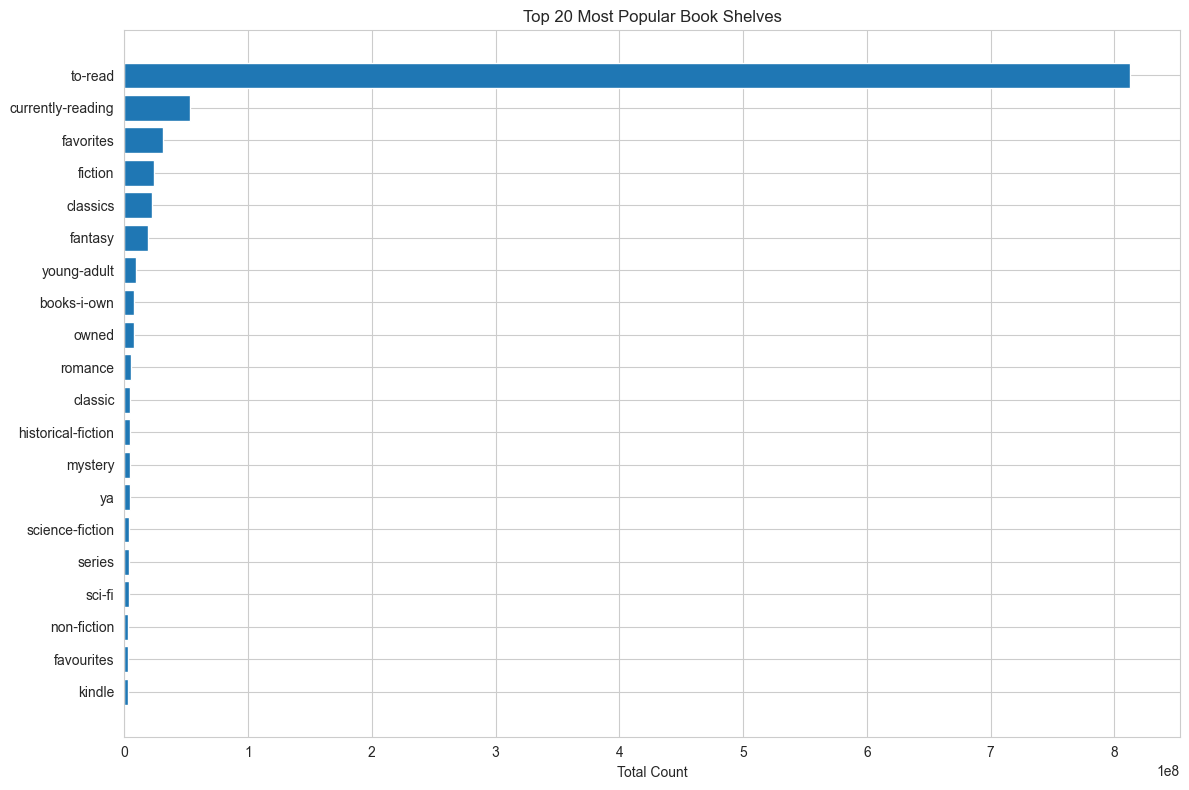

In [70]:
shelf_counter = Counter()
for shelves in books_df['popular_shelves']:
    if shelves:  # Check if not None or empty
        for shelf in shelves:
            if isinstance(shelf, dict) and 'name' in shelf and 'count' in shelf:
                shelf_counter[shelf['name']] += int(shelf['count'])

# Convert to DataFrame for easy viewing and sorting
shelves_df = pd.DataFrame(shelf_counter.items(), columns=['shelf', 'total_count'])
shelves_df = shelves_df.sort_values('total_count', ascending=False)

print("Top 20 Most Popular Shelves:")
print(shelves_df.head(20))

# Visualize top shelves
plt.figure(figsize=(12, 8))
top_shelves = shelves_df.head(20)
plt.barh(range(len(top_shelves)), top_shelves['total_count'])
plt.yticks(range(len(top_shelves)), top_shelves['shelf'])
plt.xlabel('Total Count')
plt.title('Top 20 Most Popular Book Shelves')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5. Author Analysis

Total unique authors: 176672

Top 15 Most Prolific Authors (by book count):
   author_id  book_count
0     123715         448
1       3389         436
2    5158478         314
3        947         269
4       3780         267
5        625         236
6    1221698         233
7     239579         199
8       2448         192
9      16667         191
10      1654         189
11   5481957         188
12   1077326         175
13      1265         167
14    346732         165


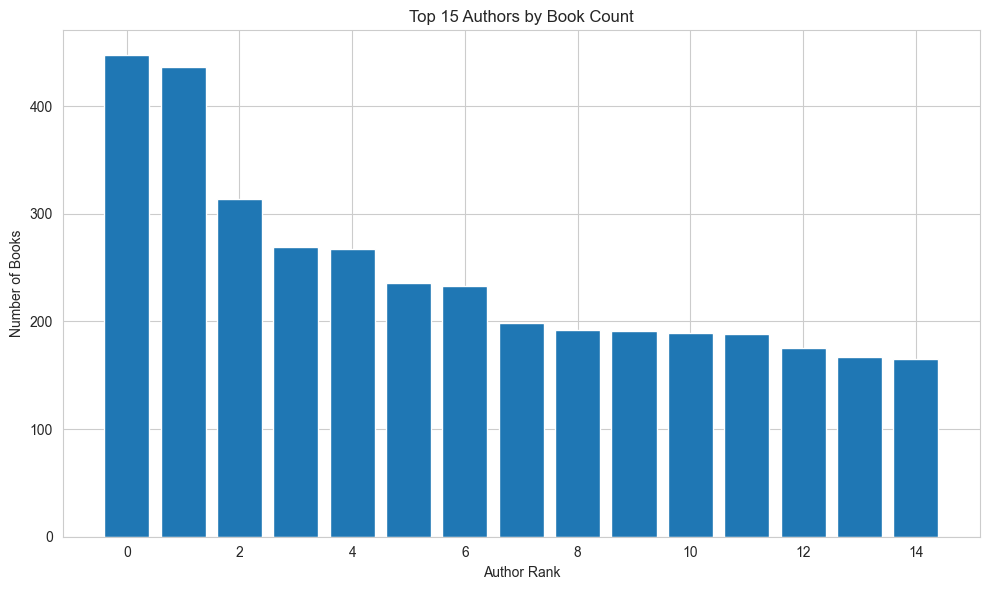

In [71]:
# Extract author information
authors_list = []
for authors in books_df['authors']:
    if authors:
        for author in authors:
            if isinstance(author, dict):
                authors_list.append(author.get('author_id', 'Unknown'))

author_counter = Counter(authors_list)
print(f"Total unique authors: {len(author_counter)}")
print(f"\nTop 15 Most Prolific Authors (by book count):")

authors_count_df = pd.DataFrame(author_counter.most_common(15), columns=['author_id', 'book_count'])
print(authors_count_df)

# Visualize
if len(authors_count_df) > 0:
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(authors_count_df)), authors_count_df['book_count'])
    plt.xlabel('Author Rank')
    plt.ylabel('Number of Books')
    plt.title('Top 15 Authors by Book Count')
    plt.tight_layout()
    plt.show()

## 6. Publication Year Analysis

Publication Year Statistics:
count    175733.000000
mean       2005.672475
std          41.943230
min           2.000000
25%        2004.000000
50%        2011.000000
75%        2014.000000
max        2025.000000
Name: publication_year, dtype: float64


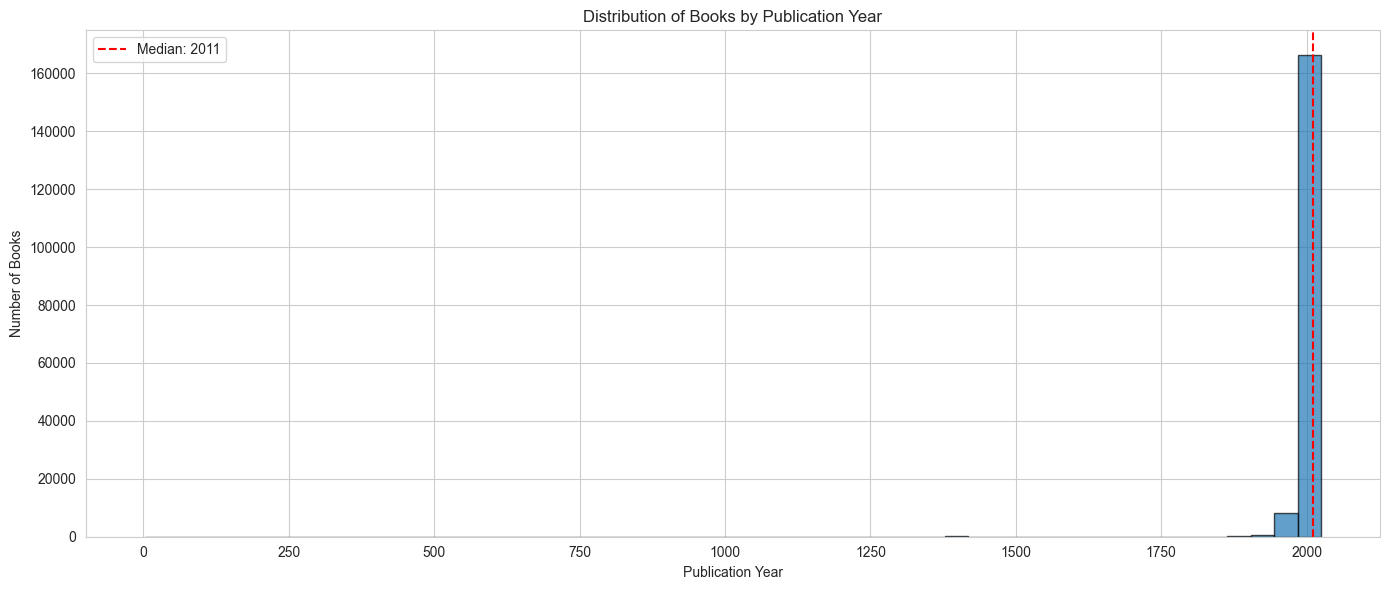

In [72]:
# Extract publication years
pub_years = books_df['publication_year'].dropna()
pub_years = pub_years[(pub_years > 0) & (pub_years < 2030)]  # Filter out invalid years

print("Publication Year Statistics:")
print(pub_years.describe())

if len(pub_years) > 0:
    plt.figure(figsize=(14, 6))
    plt.hist(pub_years, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Publication Year')
    plt.ylabel('Number of Books')
    plt.title('Distribution of Books by Publication Year')
    plt.axvline(pub_years.median(), color='red', linestyle='--', label=f"Median: {pub_years.median():.0f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

## 7. Number of Pages Analysis

Number of Pages Statistics:
count    158356.000000
mean        260.698711
std         168.318690
min           1.000000
25%         148.000000
50%         245.000000
75%         344.000000
max        1998.000000
Name: num_pages, dtype: float64


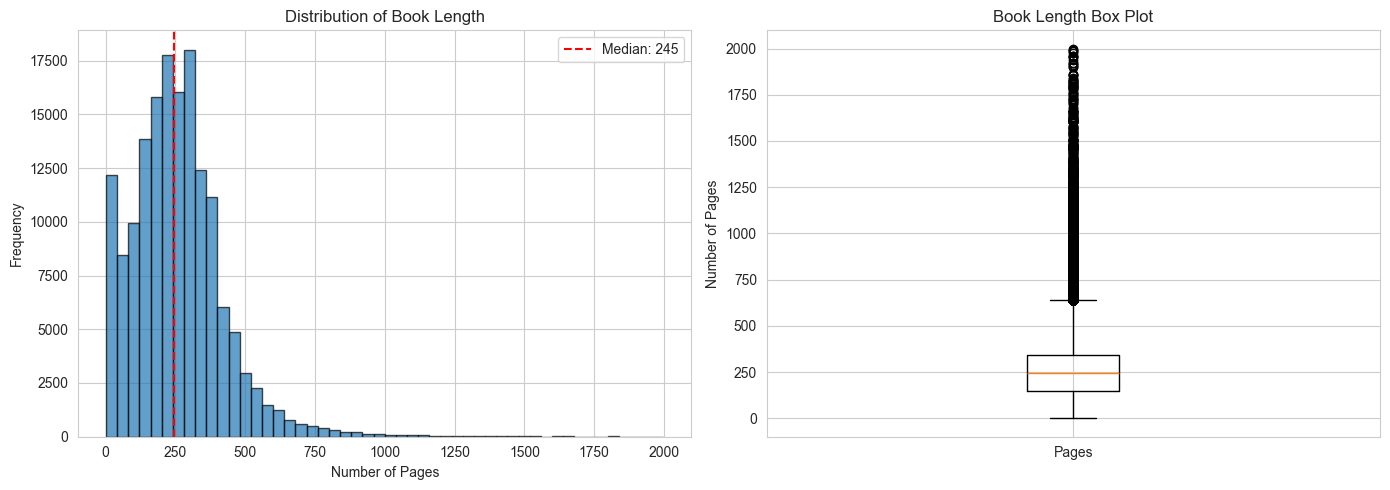

In [73]:
num_pages = books_df['num_pages'].dropna()
num_pages = num_pages[(num_pages > 0) & (num_pages < 2000)]  # Filter outliers

print("Number of Pages Statistics:")
print(num_pages.describe())

if len(num_pages) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(num_pages, bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Number of Pages')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Book Length')
    axes[0].axvline(num_pages.median(), color='red', linestyle='--', label=f"Median: {num_pages.median():.0f}")
    axes[0].legend()

    axes[1].boxplot(num_pages.tolist())
    axes[1].set_ylabel('Number of Pages')
    axes[1].set_title('Book Length Box Plot')
    axes[1].set_xticklabels(['Pages'])

    plt.tight_layout()
    plt.show()

## 8. Text Reviews Analysis

Text Reviews Statistics:
count    235942.000000
mean         27.890028
std         426.415477
min           0.000000
25%           2.000000
50%           4.000000
75%          11.000000
max       86946.000000
Name: text_reviews_count, dtype: float64


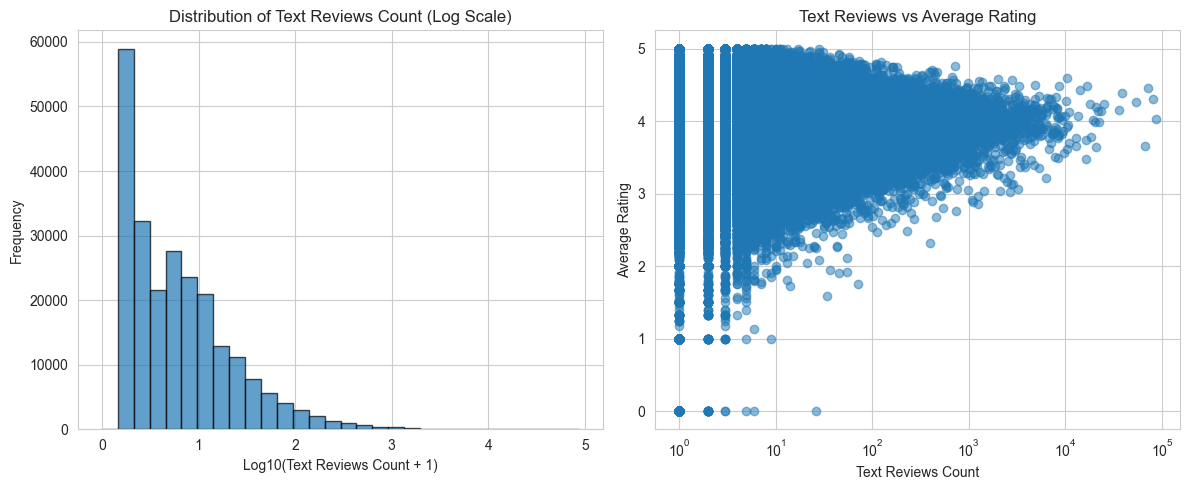

In [74]:
text_reviews = books_df['text_reviews_count'].dropna()

print("Text Reviews Statistics:")
print(text_reviews.describe())

if len(text_reviews) > 0:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(np.log10(text_reviews + 1), bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel('Log10(Text Reviews Count + 1)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Text Reviews Count (Log Scale)')

    plt.subplot(1, 2, 2)
    # Filter valid data for scatter plot
    valid_review_data = books_df[['text_reviews_count', 'average_rating']].dropna()
    plt.scatter(valid_review_data['text_reviews_count'], valid_review_data['average_rating'], alpha=0.5)
    plt.xlabel('Text Reviews Count')
    plt.ylabel('Average Rating')
    plt.title('Text Reviews vs Average Rating')
    plt.xscale('log')
    plt.tight_layout()
    plt.show()

In [75]:
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Books',
        'Unique Authors',
        'Average Rating (mean)',
        'Average Rating (median)',
        'Average Ratings Count (median)',
        'Average Text Reviews (median)',
        'Average Pages (median)',
        'Earliest Publication Year',
        'Latest Publication Year'
    ],
    'Value': [
        len(books_df),
        len(author_counter),
        f"{books_df['average_rating'].mean():.2f}" if not books_df['average_rating'].isna().all() else "N/A",
        f"{books_df['average_rating'].median():.2f}" if not books_df['average_rating'].isna().all() else "N/A",
        f"{books_df['ratings_count'].median():.0f}" if not books_df['ratings_count'].isna().all() else "N/A",
        f"{books_df['text_reviews_count'].median():.0f}" if not books_df['text_reviews_count'].isna().all() else "N/A",
        f"{num_pages.median():.0f}" if len(num_pages) > 0 else "N/A",
        f"{pub_years.min():.0f}" if len(pub_years) > 0 else "N/A",
        f"{pub_years.max():.0f}" if len(pub_years) > 0 else "N/A"
    ]
})

print("\nDataset Summary:")
print(summary_stats.to_string(index=False))


Dataset Summary:
                        Metric  Value
                   Total Books 235986
                Unique Authors 176672
         Average Rating (mean)   3.87
       Average Rating (median)   3.91
Average Ratings Count (median)     20
 Average Text Reviews (median)      4
        Average Pages (median)    245
     Earliest Publication Year      2
       Latest Publication Year   2025
